In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import json
pd.set_option('display.max_rows', 1000)
%matplotlib inline

In [3]:
# Read config
with open('config.json') as json_file:
    f = json.load(json_file)
    NUMBER_OF_QUERIES = f['number_of_queries']
    REPETITIONS = f['repetitions']
    ROWS = f['rows']
    SELECTIVITIES = [f['selectivity']]
    COLS = f['cols']
    EXPS_DEFAULTS = f['experiments']
    PARTITION_SIZE = f['partition_size']
    PROGRESSIVE_INDEX_DELTAS = f['deltas']

# Algorithms and Experiments defitions
algorithms = {
    'FullScan': {
        'name': 'full_scan_cl',
        'color': 'black',
        'dash': 'dot',
        'show_name': 'FS',
        'type': 'full_index',
        'partition_size': '0',
        'delta':'0.0',
    },
    'ProgressiveIndexTimeLimit': {
        'name': 'progressive_index_time_limit',
        'color': 'purple',
        'dash': 'dot',
        'show_name': 'PKDT(.2)',
        'type': 'adaptive',
        'delta': PROGRESSIVE_INDEX_DELTAS[0],
        'partition_size': PARTITION_SIZE
    },
    'ProgressiveIndexQueryLimit': {
        'name': 'progressive_index_query_limit',
        'color': 'purple',
        'dash': 'solid',
        'show_name': 'PKDQ(.2)',
        'type': 'adaptive',
        'delta': PROGRESSIVE_INDEX_DELTAS[0],
        'partition_size': PARTITION_SIZE
    }
}

for key, value in algorithms.items():
    name = value['name']
    delta = value['delta']
    partition_size = value['partition_size']
    algorithms[key]['alg_id'] = f"{name}-{delta}-{partition_size}"
    
# Synthetic Experiments
experiments = {}

for i in [2, 4, 8, 16]:
    temp = {
        f'Uniform{i}': {
            "name": f"Unif({i})",
            'name-in-file': 'uniform',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'Skewed{i}': {
            "name": f"Skewed({i})",
            'name-in-file': 'skewed',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'Sequential{i}': {
            "name": f"Seq ({i})",
            'name-in-file': 'sequential',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'Periodic{i}': {
            "name": f"Prdc({i})",
            'name-in-file': 'periodic',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'ZoomIn{i}': {
            "name": f"Zoom({i})",
            'name-in-file': 'zoom_in',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'SequentialZoomIn{i}': {
            "name": f"SeqZoom({i})",
            'name-in-file': 'sequential_zoom_in',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'AlternatingZoomIn{i}': {
            "name": f"AltZoom({i})",
            'name-in-file': 'alternating_zoom_in',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        },
        f'Shifting{i}': {
            "name": f"Shift({i})",
            'name-in-file': '',
            'n_rows': ROWS,
            'n_queries': NUMBER_OF_QUERIES,
            'n_cols': f'{i}',
            'sel': '0.01',
        }
    }
    experiments = {**experiments, **temp}
    
for key, value in experiments.items():
    name = value['name-in-file']
    rows = value['n_rows']
    n_queries = value['n_queries']
    cols = value['n_cols']
    sel = value['sel']
    experiments[key]['exp_id'] = f"{name}-{rows}-{n_queries}-{cols}-{sel}"

In [4]:
# Input/Output
def read(alg, exp):
    if exp.startswith('Shifting'):
        n_queries_per_run = 10
        uni = read(alg, 'Uniform' + experiments[exp]['n_cols'])
        n_runs = int(len(uni)/n_queries_per_run) - 1
        df_final = uni.head(n_queries_per_run)
        for _ in range(int(n_runs)):
            temp = uni.head(n_queries_per_run).copy()
            df_final = df_final.append(temp, ignore_index=True)
    else:
        df = pd.read_csv(f"results/{algorithms[alg]['alg_id']}-{experiments[exp]['exp_id']}.csv")
        repetitions = df['repetition'].max() + 1
        step = int(len(df.index)/repetitions)
        df_final = df[:step].copy().reset_index()
        for rep in range(1, repetitions):
            df_final += df[step * (rep) : step * (rep + 1)].copy().reset_index()

        df_final = df_final/repetitions
    
    if 'index_search_time' not in df_final:
        df_final['index_search_time'] = 0.0
    if 'tuples_scanned' not in df_final:
        df_final['tuples_scanned'] = 0.0
    if 'number_of_nodes' not in df_final:
        df_final['number_of_nodes'] = 0.0
    df_final['query_time'] = df_final['initialization_time'] + df_final['index_search_time'] + df_final['scan_time'] + df_final['adaptation_time']
    df_final['query_time_cumsum'] = df_final['query_time'].cumsum()
    return df_final

                     
def read_multiple(algs, exp):
    ''' Reads multiple algorithms in an experiment, return three arrays: dfs, colors, names
    '''
    dfs = []
    colors = []
    names = []
    dashes = []
    for alg in algs:
        dfs.append(read(alg, exp))
        names.append(algorithms[alg]['show_name'])
        colors.append(algorithms[alg]['color'])
        dashes.append(algorithms[alg]['dash'])
    
    return dfs, colors, dashes, names,

                     
def save_figure(fig, fig_name):
    fig.write_image(f"figures/{fig_name}", width=1024, height=768)
                     
def save_table(table, table_name):
    with open(f"tables/{table_name}", 'w') as f:
        f.write(table)

In [5]:
# Helper methods
def get_first_query(df):
    return df['query_time'].iloc[0]

def get_payoff(df, baseline):
    p = [i for i, x in enumerate(df['query_time_cumsum'] - (baseline['query_time_cumsum'])) if x > 0]
    if len(p) == 0:
        return len(df)
    return p[-1]

def get_convergence(df, df_type=''):
    if df_type == 'full_index':
        return 0
    c = [i for i, x in enumerate(df['adaptation_time']) if x != 0.0]
    if(len(c) == 0):
        return len(c)
    else:
        return c[-1]

def get_robustness(df, df_type=''):
    if df_type == 'full_index':
        return 0
    return np.var(df['query_time'][:min(50, get_convergence(df, df_type))])

def get_total_time(df, lower=0, upper=-1):
    return df['query_time'][lower:upper].sum()

In [6]:
# Figures

delta_cols = [2, 4, 5, 6, 7, 8]
delta_markers = ['circle', 'square', 'x', 'star', 'triangle-up', 'diamond']

def create_figure(data=[]):
    fig = go.Figure(
        data=data,
        layout=go.Layout(
#             width=1500,
            plot_bgcolor='rgba(0,0,0,0)',
            font=dict(
                size=42
            ),
            yaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgrey',
                zeroline=False,
                zerolinecolor='rgba(0, 0, 0, 0)',
                ticks="inside",
                ticklen=5
            ),
            xaxis=dict(
                showline=True,
                linewidth=2,
                linecolor='black',
                ticks='inside',
                zeroline=True,
                ticklen=5
            ),
            legend=dict(
                font=dict(
                    size=30,
                    color="black"
                )
            )
        )
    )
    return fig

def line(exp, algs, attr, limit=2000):
    dfs, colors, dashes, names = read_multiple(algs, exp)
    fig = create_figure()
    
    lines = []
    
    biggest = 0
    
    for i, df in enumerate(dfs):
        per_query_times = np.array(df[attr][:limit])
        if biggest < np.max(per_query_times):
            biggest = np.max(per_query_times)
        lines.append(
            go.Scatter(
                name=names[i],
                x=list(range(len(per_query_times))),
                y=per_query_times,
#                 marker_color=colors[i],
                mode='lines',
                line=dict(width=4, dash=dashes[i])
            )
        )
    
    fig.add_traces(data=lines)
    fig.update_layout(showlegend=True, yaxis_title=attr)
    return fig

def workload_selectivity(exp):
    fig = create_figure()
    df = read('FullScan', exp)
    sel = ((df['tuples_scanned']/df['scan_overhead'])/df['tuples_scanned']) * 100
    
    fig.add_traces(
        data=go.Scatter(
            name='selectivity',
            x=list(range(len(sel))),
            y=sel,
            mode='lines',
            line=dict(width=4)
        )
    )
    fig.update_layout(showlegend=True, yaxis_title='Selectivity (%)')
    return fig


def per_query(exp, algs, limit=1000):
    dfs, colors, dashes, names = read_multiple(algs, exp)
    fig = create_figure()
    
    lines = []
    
    biggest = 0
    
    for i, df in enumerate(dfs):
        alg = algs[i]
        per_query_times = np.array(df['query_time'][:limit]) * 1000
        if biggest < np.max(per_query_times):
            biggest = np.max(per_query_times)
        lines.append(
            go.Scatter(
                name=names[i],
                x=list(range(len(per_query_times))),
                y=per_query_times,
                marker_color=colors[i],
                mode='lines',
                line=dict(width=6, dash=dashes[i])
            )
        )
        
    fig.add_traces(data=lines)
    fig.update_layout(showlegend=True, yaxis_title='Time (milliseconds)')
    fig.update_layout(legend_orientation="h", legend=dict(x=.25, y=1.2))
    fig.update_yaxes(type="log")
    return fig

def cummulative(exp, algs, limit=5000):
    dfs, colors, dashes, names = read_multiple(algs, exp)
    fig = create_figure()
    
    lines = []
    
    biggest = 0
    
    for i, df in enumerate(dfs):
        alg = algs[i]
        per_query_times = np.array(df['query_time_cumsum'][:limit])
        lines.append(
            go.Scatter(
                name=names[i],
                x=list(range(len(per_query_times))),
                y=per_query_times,
                marker_color=colors[i],
                mode='lines',
                line=dict(width=6, dash=dashes[i])
            )
        )
    
    fig.add_traces(data=lines)
    fig.update_layout(legend_orientation="h", legend=dict(x=.25, y=1.2))
    fig.update_layout(showlegend=True, yaxis_title='Time (Seconds)')
    return fig

def number_of_nodes(exp, algs, limit=5000):
    dfs, colors, dashes, names = read_multiple(algs, exp)
    fig = create_figure()
    
    lines = []
    
    biggest = 0
    
    for i, df in enumerate(dfs):
        per_query_times = np.array(df['number_of_nodes'][:limit])
        if biggest < np.max(per_query_times):
            biggest = np.max(per_query_times)
        lines.append(
            go.Scatter(
                name=names[i],
                x=list(range(len(per_query_times))),
                y=per_query_times,
                marker_color=colors[i],
                mode='lines',
                line=dict(width=6, dash=dashes[i])
            )
        )
    
    fig.add_traces(data=lines)
    fig.update_layout(legend_orientation="h", legend=dict(x=.25, y=1.2))
    fig.update_layout(showlegend=True, yaxis_title='# Nodes')
    return fig

def tuples_scanned(exp, algs, limit=5000):
    dfs, colors, dashes, names = read_multiple(algs, exp)
    fig = create_figure()
    
    lines = []
    
    
    for i, df in enumerate(dfs):
        per_query_times = np.array(df['tuples_scanned'][:limit])
        lines.append(
            go.Scatter(
                name=names[i],
                x=list(range(len(per_query_times))),
                y=per_query_times,
                marker_color=colors[i],
                mode='lines',
                line=dict(width=6, dash=dashes[i])
            )
        )
    
    fig.add_traces(data=lines)
    fig.update_layout(legend_orientation="h", legend=dict(x=.25, y=1.2))
    fig.update_layout(showlegend=True, yaxis_title='Tuples Scanned')
    return fig

def break_down(exp, algs, limit):
    dfs, _, _, names = read_multiple(algs, exp)
    initializations = np.array([x['initialization_time'][:limit].sum() for x in dfs])
    adaptation = np.array([x['adaptation_time'][:limit].sum() for x in dfs])
    search = np.array([x['index_search_time'][:limit].sum() for x in dfs])
    scan = np.array([x['scan_time'][:limit].sum() for x in dfs])
    
#     fig = create_figure(data=[
#         go.Bar(name='Initialization', x=names, y=initializations, marker_color='rgb(176, 201, 146)'),
#         go.Bar(name='Adaptation', x=names, y=adaptation, marker_color='rgb(195, 114, 28)'),
#         go.Bar(name='Index Search', x=names, y=search, marker_color='rgb(197, 255, 114)'),
#         go.Bar(name='Scan', x=names, y=scan, marker_color='rgb(237, 218, 123)'),
#     ])

    scan_color = '#AB63FA'
    index_search_color = '#03CC96'
    adaptation_color = '#EF553B'
    initialization_color = '#636EFA'

    data = [
        go.Bar(name='Initialization', x=names, y=initializations, width=0.5, marker_color=initialization_color, showlegend=False),
        go.Bar(name='Adaptation', x=names, y=adaptation, width=0.5, marker_color=adaptation_color, showlegend=False),
        go.Bar(name='Index Search', x=names, y=search, width=0.5, marker_color=index_search_color,showlegend=False),
        go.Bar(name='Scan', x=names, y=scan, width=0.5, marker_color=scan_color,showlegend=False),
    ]
    
    data.append(
        go.Scatter(
            name='Initialization',
            x=[None],
            y=[None],
            mode='markers',
            marker_color=initialization_color,
            marker=dict(
                size=40,
                symbol='square'
            ),
        )
    )
    
    data.append(
        go.Scatter(
            name='Adaptation',
            x=[None],
            y=[None],
            mode='markers',
            marker_color=adaptation_color,
            marker=dict(
                size=40,
                symbol='square'
            ),
        )
    )
    
    data.append(
        go.Scatter(
            name='Index Search',
            x=[None],
            y=[None],
            mode='markers',
            marker_color=index_search_color,
            marker=dict(
                size=40,
                symbol='square'
            ),
        )
    )
    
    data.append(
        go.Scatter(
            name='Scan',
            x=[None],
            y=[None],
            mode='markers',
            marker_color=scan_color,
            marker=dict(
                size=40,
                symbol='square'
            ),
        )
    )

    fig = create_figure(data=data)
    
    # Change the bar mode
    fig.update_layout(barmode='stack')
    fig.update_layout(legend_orientation="h", legend=dict(x=.25, y=1.2))
    fig.update_layout(yaxis_title='Time (seconds)')
    return fig

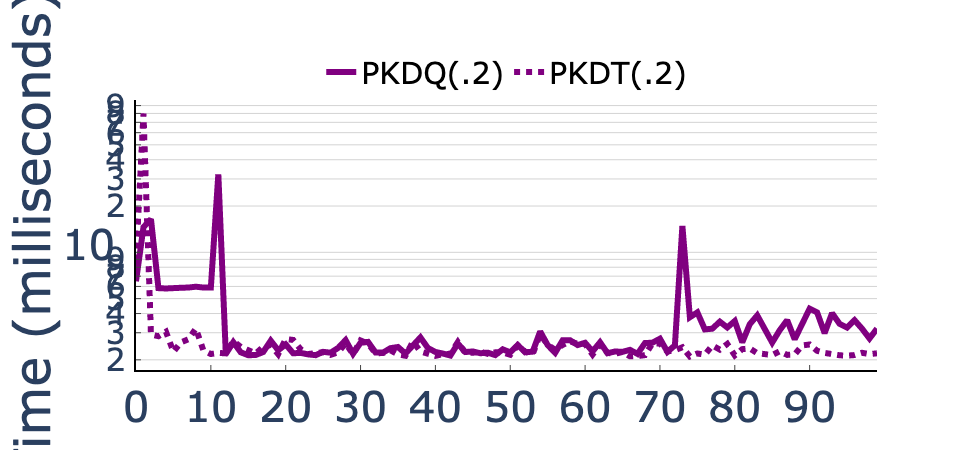

In [11]:
per_query('Uniform8', ['ProgressiveIndexQueryLimit', 'ProgressiveIndexTimeLimit'], 100)